In [1]:
import numpy as np
from simulation import Simulation
from lineages import Lineage
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

%load_ext autoreload

In [2]:
%autoreload 2

In [12]:
import matplotlib
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [4]:
time_res = np.arange(1/120, 10, 0.05)
print(time_res)

[8.33333333e-03 5.83333333e-02 1.08333333e-01 1.58333333e-01
 2.08333333e-01 2.58333333e-01 3.08333333e-01 3.58333333e-01
 4.08333333e-01 4.58333333e-01 5.08333333e-01 5.58333333e-01
 6.08333333e-01 6.58333333e-01 7.08333333e-01 7.58333333e-01
 8.08333333e-01 8.58333333e-01 9.08333333e-01 9.58333333e-01
 1.00833333e+00 1.05833333e+00 1.10833333e+00 1.15833333e+00
 1.20833333e+00 1.25833333e+00 1.30833333e+00 1.35833333e+00
 1.40833333e+00 1.45833333e+00 1.50833333e+00 1.55833333e+00
 1.60833333e+00 1.65833333e+00 1.70833333e+00 1.75833333e+00
 1.80833333e+00 1.85833333e+00 1.90833333e+00 1.95833333e+00
 2.00833333e+00 2.05833333e+00 2.10833333e+00 2.15833333e+00
 2.20833333e+00 2.25833333e+00 2.30833333e+00 2.35833333e+00
 2.40833333e+00 2.45833333e+00 2.50833333e+00 2.55833333e+00
 2.60833333e+00 2.65833333e+00 2.70833333e+00 2.75833333e+00
 2.80833333e+00 2.85833333e+00 2.90833333e+00 2.95833333e+00
 3.00833333e+00 3.05833333e+00 3.10833333e+00 3.15833333e+00
 3.20833333e+00 3.258333

In [5]:
simulations = []
for x in range(200):
    sim = Simulation(dt=1/120, Delta=np.random.uniform(8, 12), D_sd=3, tau=np.random.uniform(18, 22), t_sd=3) # 2fps, averge doubling time 20 mins, adder at 10
    OD = sim.run(length=500, vm=np.random.uniform(15, 25), n=2) # initialise mother cell with various lengths
    simulations.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 41748.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:02<00:00, 23043.55it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 39580.65it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 33459.52it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:02<00:00, 22225.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 35881.88it/s]


In [7]:
lineages = Lineage(simulations, cell=-1)

# Try find the mother-daughter correlation

In [8]:
mothers_tau1 = []
daughters_tau1 = []
for l in lineages.divisions_t:
    true_div_times = [l[j+1] - l[j] for j in range(len(l) - 1)]
    tmother = true_div_times[:-1]
    tdaughter = true_div_times[1:]
    mothers_tau1.extend(tmother)
    daughters_tau1.extend(tdaughter)
slope1, _, __, ___, ____ = linregress(mothers_tau1, daughters_tau1)
true_c = slope1

m1 = np.mean([l[j+1] - l[j] for l in lineages.divisions_t for j in range(len(l) - 1)])
v1 = np.var([l[j+1] - l[j] for l in lineages.divisions_t for j in range(len(l) - 1)])
print(true_c, m1, v1)

true_fitness = 2 * np.log(2) / m1 / (1 + np.sqrt(1 - 2 * np.log(2) * v1 / m1**2 * (1 + true_c) / (1 - true_c)))
print(true_fitness)

0.2874554028660897 22.815746397243107 31.35028273967478
0.03162146531203172


In [8]:
div_times, div_lengths = lineages.collect_downsampled_data(n=240) # 2 mins time step

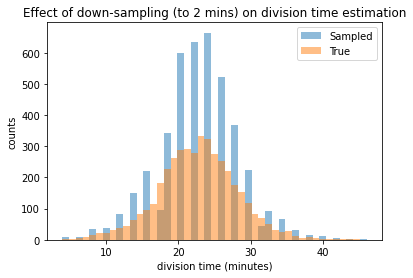

In [9]:
true_div_times = [l[j+1] - l[j] for l in lineages.divisions_t for j in range(len(l) - 1)]
est_div_times = [item for sublist in div_times for item in sublist]
count1, bins, p1 = plt.hist(np.array(est_div_times), 45, alpha=0.5, label="Sampled")
count2, bins, p2 = plt.hist(np.array(true_div_times), alpha=0.5, label="True", bins=bins)
plt.legend()
plt.xlabel("division time (minutes)")
plt.ylabel("counts")
plt.title("Effect of down-sampling (to 2 mins) on division time estimation")
plt.show()

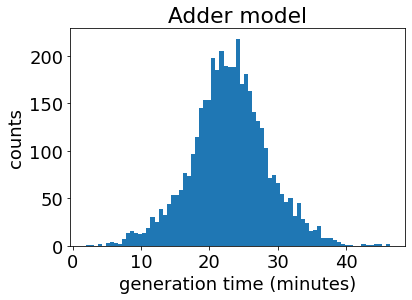

In [23]:
true_div_times = [l[j+1] - l[j] for l in lineages.divisions_t for j in range(len(l) - 1)]
est_div_times = [item for sublist in div_times for item in sublist]
count2, bins, p2 = plt.hist(np.array(true_div_times), alpha=1, label="True", bins=75)
# plt.legend()
plt.xlabel("generation time (minutes)")
plt.ylabel("counts")
plt.title("Adder model")
plt.show()

check thrid and forth moment

adder model estimation (just maximum likelihood)

In [10]:
# count1, bins, p1 = plt.hist(np.array(est_div_times), 12, alpha=0.5, label="Estimated")
# count2, bins, p2 = plt.hist(np.array(true_div_times), alpha=0.5, label="True", bins=bins)
# plt.legend()
# plt.xlabel("division time (minutes)")
# plt.ylabel("counts")
# plt.title("Effect of down-sampling (to 2 mins) on division time estimation")
# plt.show()

In [11]:
# c1, bins = np.histogram(np.array(est_div_times), 20)
# c2, bins = np.histogram(np.array(true_div_times), bins=bins)
# print(c2)
# print(count2)

In [12]:
# true_div_lengths = [lineages.lineages[l][j] for l in range(len(lineages.divisions_idx)) for j in lineages.divisions_idx[l]]
# est_div_lengths = [item for sublist in div_lengths for item in sublist]
# count1, bins, p1 = plt.hist(np.array(est_div_lengths), 25, alpha=0.5, label="Estimated")
# count2, bins, p2 = plt.hist(np.array(true_div_lengths), alpha=0.5, label="True", bins=bins)
# plt.legend()
# plt.xlabel("division volume")
# plt.ylabel("counts")
# plt.title("Effect of down-sampling (to 2 mins) on division volume estimation")
# plt.show()

The bins width should be carefully considered. There should also be some better ways of comparing distributions and quantifying their differences. 

In [9]:
errors_t = []
errors_v = []
mean_true = []
var_true = []
mean_est = []
var_est = []
mean2_true = []
var2_true = []
mean2_est = []
var2_est = []
sk_true = []
kur_true = []
sk_est = []
kur_est = []
sk2_true = []
kur2_true = []
sk2_est = []
kur2_est = []

c_est = []
fitness_est = []

true_div_times = [l[j+1] - l[j] for l in lineages.divisions_t for j in range(len(l) - 1)]
for t in time_res:
    
    div_times, div_lengths = lineages.collect_downsampled_data(n=round(t*120))
    
    bin_number = 50
    
    est_div_times = [item for sublist in div_times for item in sublist]
    m1 = np.mean(true_div_times)
    m2 = np.mean(est_div_times)
    v1 = np.var(true_div_times)
    v2 = np.var(est_div_times)
    mean_true.append(m1)
    mean_est.append(m2)
    var_true.append(v1)
    var_est.append(v2)
    sk_true.append(skew(true_div_times))
    sk_est.append(skew(est_div_times))
    kur_true.append(kurtosis(true_div_times))
    kur_est.append(kurtosis(est_div_times))
    
    mothers_tau = []
    daughters_tau = []
    for sublist in div_times:
        tmother = sublist[:-1]
        tdaughter = sublist[1:]
        mothers_tau.extend(tmother)
        daughters_tau.extend(tdaughter)
    slope, _, __, ___, ____ = linregress(mothers_tau, daughters_tau)
    mother_daughter_c = slope
    c_est.append(mother_daughter_c)
    
    fitness = 2 * np.log(2) / m2 / (1 + np.sqrt(1 - 2 * np.log(2) * v2 / m2**2 * (1 + mother_daughter_c) / (1 - mother_daughter_c)))
    fitness_est.append(fitness)
    
    count1, bins = np.histogram(np.array(est_div_times), bin_number)
    count2, bins = np.histogram(np.array(true_div_times), bins=bins)
    errors_t.append(sum(abs(count1 - count2)))
    
#     bin_number = 20
    
#     true_div_lengths = [lineages.lineages[l][j] for l in range(len(lineages.divisions_idx)) for j in lineages.divisions_idx[l]]
#     est_div_lengths = [item for sublist in div_lengths for item in sublist]
#     m1 = np.mean(true_div_lengths)
#     m2 = np.mean(est_div_lengths)
#     v1 = np.var(true_div_lengths)
#     v2 = np.var(est_div_lengths)
#     mean2_true.append(m1)
#     mean2_est.append(m2)
#     var2_true.append(v1)
#     var2_est.append(v2)
#     sk2_true.append(skew(true_div_lengths))
#     sk2_est.append(skew(est_div_lengths))
#     kur2_true.append(kurtosis(true_div_lengths))
#     kur2_est.append(kurtosis(est_div_lengths))
#     count1, bins = np.histogram(np.array(est_div_lengths), bin_number)
#     count2, bins = np.histogram(np.array(true_div_lengths), bins=bins)
#     errors_v.append(sum(abs(count1 - count2)))

In [11]:
# plt.plot(time_res, errors_t, label="division time")
# plt.plot(time_res, errors_v, label="division volume")
# plt.xscale("log")
# plt.xlabel("sampling time interval (minutes)")
# plt.ylabel("counts")
# plt.title("Difference between two histograms")
# plt.legend()
# plt.show()

In [12]:
print(mean_true[0])

22.827825389371526


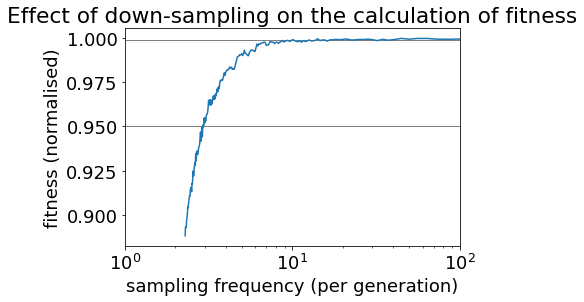

In [37]:
# plt.plot(time_res, mean_true, label="true")
plt.hlines(0.95, 1, 100, color='0.5', linewidth=1)
plt.hlines(0.999, 1, 100, color='0.5', linewidth=1)
plt.plot(mean_true[0]/time_res, fitness_est/true_fitness, label="est")
plt.xscale("log")
plt.xlabel("sampling frequency (per generation)")
plt.ylabel("fitness (normalised)")
plt.title("Effect of down-sampling on the calculation of fitness")
plt.xlim(1, 100)

# plt.legend()
plt.show()

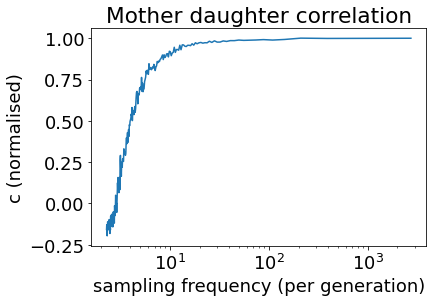

In [14]:
# plt.plot(time_res, mean_true, label="true")
plt.plot(mean_true[0]/time_res, c_est/true_c, label="est")
plt.xscale("log")
plt.xlabel("sampling frequency (per generation)")
plt.ylabel("c (normalised)")
plt.title("Mother daughter correlation")
# plt.legend()
plt.show()

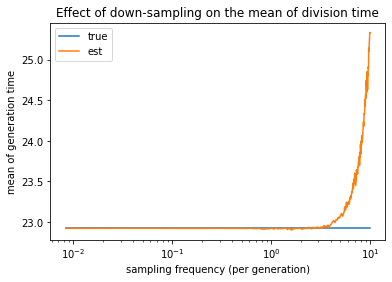

In [8]:
plt.plot(time_res, mean_true, label="true")
plt.plot(time_res, mean_est, label="est")
plt.xscale("log")
plt.xlabel("sampling frequency (per generation)")
plt.ylabel("mean of generation time")
plt.title("Effect of down-sampling on the mean of division time")
plt.legend()
plt.show()

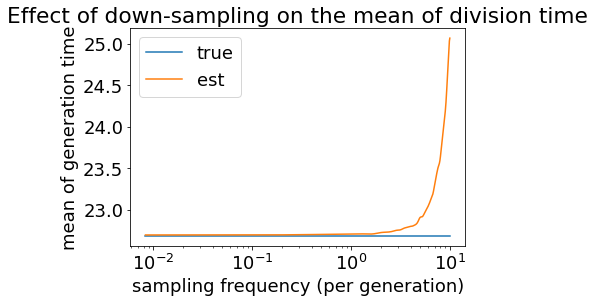

In [39]:
plt.plot(time_res, mean_true, label="true")
plt.plot(time_res, gaussian_filter1d(mean_est, 3), label="est")
plt.xscale("log")
plt.xlabel("sampling frequency (per generation)")
plt.ylabel("mean of generation time")
plt.title("Effect of down-sampling on the mean of division time")
plt.legend()
plt.show()

In [9]:
def xunder(ts, thresh):
#     x = gaussian_filter1d(ts, 1) < thresh
    x = ts < thresh
    return x.argmin() if x.any() else -1

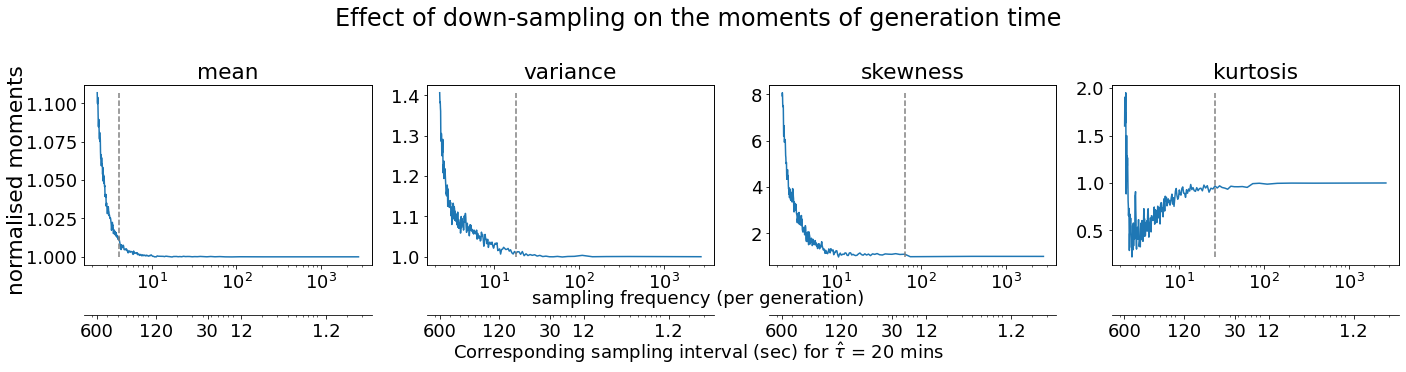

In [110]:
avg_gen = mean_true[0]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Effect of down-sampling on the moments of generation time", fontsize=24)
axes[0].plot(mean_true[0]/time_res, mean_est/mean_true[0], label="est")
axes[0].set_xscale("log")
idx = xunder(abs(mean_est/mean_true[0] - 1), 0.01)
axes[0].vlines(mean_true[0]/time_res[idx], min(mean_est/mean_true[0]), max(mean_est/mean_true[0]), color='0.5', linestyles='dashed')
axes[0].set_title("mean")

axes[1].plot(mean_true[0]/time_res, var_est/var_true[0], label="est")
axes[1].set_xscale("log")
idx = xunder(abs(var_est/var_true[0] - 1), 0.01)
axes[1].vlines(mean_true[0]/time_res[idx], min(var_est/var_true[0]), max(var_est/var_true[0]), color='0.5', linestyles='dashed')
axes[1].set_title("variance")

axes[2].plot(mean_true[0]/time_res, np.array(sk_est)/sk_true[0], label="est")
axes[2].set_xscale("log")
idx = xunder(abs(np.array(sk_est)/sk_true[0] - 1), 0.05)
axes[2].vlines(mean_true[0]/time_res[idx], min(np.array(sk_est)/sk_true[0]), max(np.array(sk_est)/sk_true[0]), color='0.5', linestyles='dashed')
axes[2].set_title("skewness")

axes[3].plot(mean_true[0]/time_res, np.array(kur_est)/kur_true[0], label="est")
axes[3].set_xscale("log")
idx = xunder(abs(np.array(kur_est)/kur_true[0] - 1), 0.05)
axes[3].vlines(mean_true[0]/time_res[idx], min(np.array(kur_est)/kur_true[0]), max(np.array(kur_est)/kur_true[0]), color='0.5', linestyles='dashed')
axes[3].set_title("kurtosis")

# axes[0].set_xlabel("sampling frequency")
fig.text(0.5, 0.17, 'sampling frequency (per generation)', ha='center', va='center')

# fig.supxlabel("sampling frequency (per generation)")
fig.supylabel("normalised moments")

fig.text(0.5, 0.02, r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

ax20 = axes[0].twiny()
ax20.set_xscale("log")
newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax20.set_xticks(newpos)
ax20.set_xticklabels(newlabel)

ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax20.spines['bottom'].set_position(('outward', 50))
# ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
ax20.set_xlim(axes[0].get_xlim())

ax21 = axes[1].twiny()
ax21.set_xscale("log")
ax21.set_xticks(newpos)
ax21.set_xticklabels(newlabel)

ax21.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax21.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax21.spines['bottom'].set_position(('outward', 50))
ax21.set_xlim(axes[1].get_xlim())

ax22 = axes[2].twiny()
ax22.set_xscale("log")
ax22.set_xticks(newpos)
ax22.set_xticklabels(newlabel)

ax22.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax22.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax22.spines['bottom'].set_position(('outward', 50))
ax22.set_xlim(axes[2].get_xlim())

ax23 = axes[3].twiny()
ax23.set_xscale("log")
ax23.set_xticks(newpos)
ax23.set_xticklabels(newlabel)

ax23.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax23.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax23.spines['bottom'].set_position(('outward', 50))
ax23.set_xlim(axes[3].get_xlim())
plt.tight_layout()
plt.show()


23.185503731343285 22.92218224005034
35.6288214191403 32.1602010326215


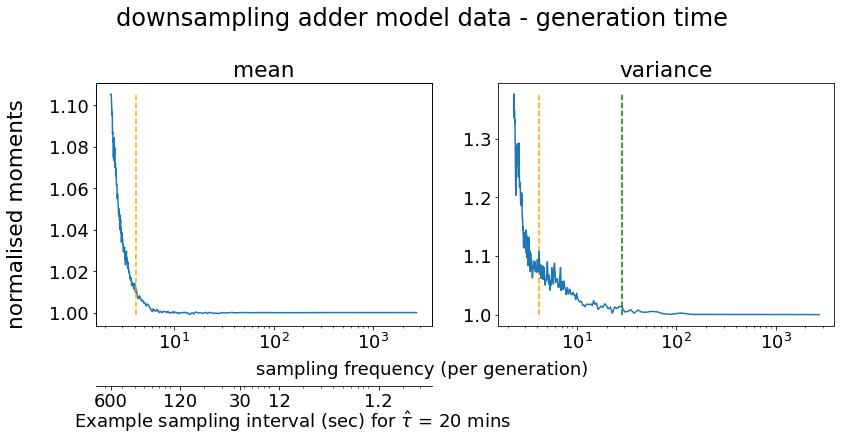

In [18]:
avg_gen = mean_true[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("downsampling adder model data - generation time", fontsize=24)
axes[0].plot(mean_true[0]/time_res, mean_est/mean_true[0], label="est")
axes[0].set_xscale("log")
idx = xunder(abs(mean_est/mean_true[0] - 1), 0.01)
axes[0].vlines(mean_true[0]/time_res[idx], min(mean_est/mean_true[0]), max(mean_est/mean_true[0]), 
               color='orange', linestyles='dashed')
print(mean_est[idx], mean_true[0])
m2 = mean_est[idx]
axes[1].vlines(mean_true[0]/time_res[idx], min(var_est/var_true[0]), max(var_est/var_true[0]), 
               color='orange', linestyles='dashed')
print(var_est[idx], var_true[0])
v2 = var_est[idx]
axes[0].set_title("mean")

axes[1].plot(mean_true[0]/time_res, var_est/var_true[0], label="est")
axes[1].set_xscale("log")
idx = xunder(abs(var_est/var_true[0] - 1), 0.01)
axes[1].vlines(mean_true[0]/time_res[idx], min(var_est/var_true[0]), max(var_est/var_true[0]), 
               color='green', linestyles='dashed')
m3 = mean_est[idx]
v3 = var_est[idx]
axes[1].set_title("variance")

# axes[0].plot(mean_true[0]/time_res, np.array(sk_est)/sk_true[0], label="est")
# axes[0].set_xscale("log")
# idx3 = xunder(np.array(abs(np.array(sk_est)/sk_true[0] - 1)), 0.01)
# axes[0].vlines(mean_true[0]/time_res[idx3], min(np.array(sk_est)/sk_true[0]), max(np.array(sk_est)/sk_true[0]), color='0.5', linestyles='dashed')
# axes[0].set_title("skewness")

# axes[1].plot(mean_true[0]/time_res, np.array(kur_est)/kur_true[0], label="est")
# axes[1].set_xscale("log")
# idx4 = xunder(abs(np.array(kur_est)/kur_true[0] - 1), 0.01)
# axes[1].vlines(mean_true[0]/time_res[idx4], min(np.array(kur_est)/kur_true[0]), max(np.array(kur_est)/kur_true[0]), color='0.5', linestyles='dashed')
# axes[1].set_title("kurtosis")

# axes[0].set_xlabel("sampling frequency")
fig.text(0.5, 0.14, 'sampling frequency (per generation)', ha='center', va='center')

# fig.supxlabel("sampling frequency (per generation)")
fig.supylabel("normalised moments")

fig.text(0.35, 0.02, r'Example sampling interval (sec) for $\hat{\tau}$ = 20 mins', ha='center', va='center')

ax20 = axes[0].twiny()
ax20.set_xscale("log")
newlabel = [600,120,30,12,1.2] # labels of the xticklabels: the position in the new x-axis
t2f = lambda t: mean_true[0]/(t/60) # convert function: from Kelvin to Degree Celsius
newpos   = [t2f(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax20.set_xticks(newpos)
ax20.set_xticklabels(newlabel)

ax20.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax20.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax20.spines['bottom'].set_position(('outward', 60))
# ax20.set_xlabel(r'Corresponding sampling interval (sec) for $\hat{\tau}$ = 20 mins')
ax20.set_xlim(axes[0].get_xlim())

# ax21 = axes[1].twiny()
# ax21.set_xscale("log")
# ax21.set_xticks(newpos)
# ax21.set_xticklabels(newlabel)

# ax21.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
# ax21.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
# ax21.spines['bottom'].set_position(('outward', 50))
# ax21.set_xlim(axes[1].get_xlim())

# ax22 = axes[2].twiny()
# ax22.set_xscale("log")
# ax22.set_xticks(newpos)
# ax22.set_xticklabels(newlabel)

# ax22.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
# ax22.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
# ax22.spines['bottom'].set_position(('outward', 50))
# ax22.set_xlim(axes[2].get_xlim())

# ax23 = axes[3].twiny()
# ax23.set_xscale("log")
# ax23.set_xticks(newpos)
# ax23.set_xticklabels(newlabel)

# ax23.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
# ax23.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
# ax23.spines['bottom'].set_position(('outward', 50))
# ax23.set_xlim(axes[3].get_xlim())
plt.tight_layout()
plt.show()


In [45]:
print(2 * np.log(2) / m2 / (1 + np.sqrt(1 - 2 * np.log(2) * v2 / m2**2 * (1 + true_c) / (1 - true_c))))
print(2 * np.log(2) / m3 / (1 + np.sqrt(1 - 2 * np.log(2) * v3 / m3**2 * (1 + true_c) / (1 - true_c))))
print(2 * np.log(2) / m3 / (1 + np.sqrt(1 - 2 * np.log(2) * v2 / m3**2 * (1 + true_c) / (1 - true_c))))
print(true_fitness)

0.031374853027674884
0.03162198657042208
0.031707890704908606
0.031615150609027275


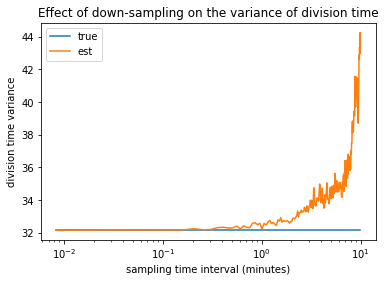

In [10]:
plt.plot(time_res, var_true, label="true")
plt.plot(time_res, var_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division time variance")
plt.title("Effect of down-sampling on the variance of division time")
plt.legend()
plt.show()

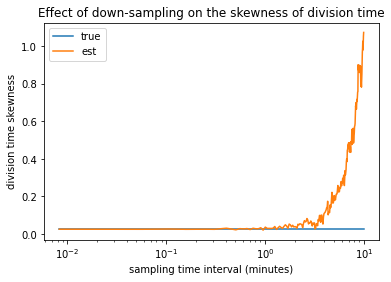

In [11]:
plt.plot(time_res, sk_true, label="true")
plt.plot(time_res, sk_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division time skewness")
plt.title("Effect of down-sampling on the skewness of division time")
plt.legend()
plt.show()

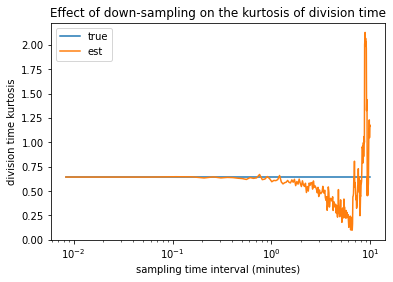

In [12]:
plt.plot(time_res, kur_true, label="true")
plt.plot(time_res, kur_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division time kurtosis")
plt.title("Effect of down-sampling on the kurtosis of division time")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

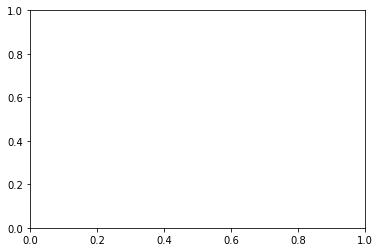

In [17]:
plt.plot(time_res, mean2_true, label="true")
plt.plot(time_res, mean2_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("mean division volume")
plt.title("Effect of down-sampling on the mean of division volume")
plt.legend()
plt.show()

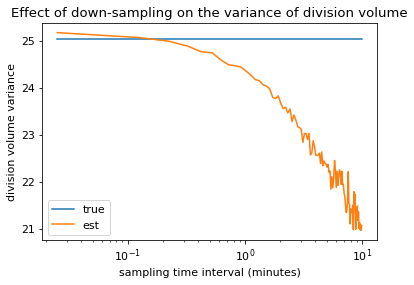

In [93]:
plt.plot(time_res, var2_true, label="true")
plt.plot(time_res, var2_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division volume variance")
plt.title("Effect of down-sampling on the variance of division volume")
plt.legend()
plt.show()

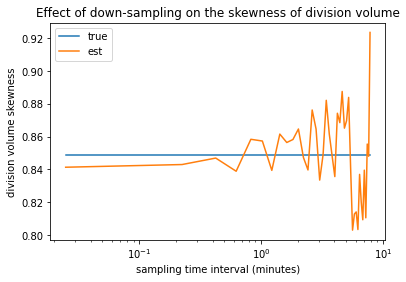

In [22]:
plt.plot(time_res, sk2_true, label="true")
plt.plot(time_res, sk2_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division volume skewness")
plt.title("Effect of down-sampling on the skewness of division volume")
plt.legend()
plt.show()

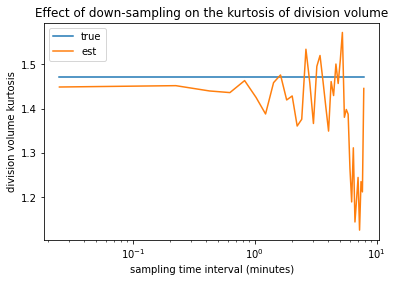

In [23]:
plt.plot(time_res, kur2_true, label="true")
plt.plot(time_res, kur2_est, label="est")
plt.xscale("log")
plt.xlabel("sampling time interval (minutes)")
plt.ylabel("division volume kurtosis")
plt.title("Effect of down-sampling on the kurtosis of division volume")
plt.legend()
plt.show()